# Recap example: Monte-Carlo

## Problem: Implement and test a simple Monte-Carlo algorithm

Given an input function (energy) and starting point (density) and a temperature $T$: 

1. Compute energy at current density.
1. Move randomly chosen agent randomly left or right.
1. Compute second energy.
1. Compare the two energies:
1. If second energy is lower, accept move.
1. $\beta$ is a parameter which determines how likely
   the simulation is to move from a 'less favourable' situation to a 'more favourable' one.
1. Compute $P_0=e^{-\beta (E_1 - E_0)}$ and $P_1$ a random number between 0 and 1,
1. If $P_0 > P_1$, do the move anyway.
1. Repeat.

* the algorithm should work for (m)any energy function(s).
* there should be separate tests for separate steps! What constitutes a step?
* tests for the Monte-Carlo should not depend on other parts of code.
* Use [matplotlib](http://matplotlib.org/) to plot density at each iteration, and make an animation

**NB.** If you are using the Windows command prompt, you will have to replace all `%%bash` directives in this notebook with `%%cmd` 

## Solution

We need to break our problem down into pieces:

1. A function to generate a random change: `random_agent()`, `random_direction()`
1. A function to compute the energy before the change and after it: `energy()`
1. A function to determine the probability of a change given the energy difference (1 if decreases, otherwise based on exponential): `change_density()`
1. A function to determine whether to execute a change or not by drawing a random number`accept_change()`
1. A method to iterate the above procedure: `step()`

Next Step: Think about the possible unit tests

1. Input insanity: e.g. density should non-negative integer; testing by giving negative values etc.
1. `change_density()`: density is change by a particle hopping left or right? Do all positions have an equal chance of moving?
1. `accept_change()` will move be accepted when second energy is lower?
1. Make a small test case for the main algorithm. (Hint: by using mocking, we can pre-set who to move where.)

In [1]:
%%bash
rm -rf DiffusionExample
mkdir DiffusionExample

**Windows:** You will need to run the following instead
    
```cmd
%%cmd
rmdir /s DiffusionExample
mkdir DiffusionExample
```

In [2]:
%%writefile DiffusionExample/MonteCarlo.py
import matplotlib.pyplot as plt
from numpy import sum, array
from numpy.random import randint, choice


class MonteCarlo:
    """A simple Monte Carlo implementation"""

    def __init__(self, energy, density, temperature=1, itermax=1000):
        from numpy import any, array

        density = array(density)
        self.itermax = itermax

        if temperature == 0:
            raise NotImplementedError("Zero temperature not implemented")
        if temperature < 0e0:
            raise ValueError("Negative temperature makes no sense")

        if len(density) < 2:
            raise ValueError("Density is too short")
        # of the right kind (integer). Unless it is zero length,
        # in which case type does not matter.
        if density.dtype.kind != "i" and len(density) > 0:
            raise TypeError("Density should be an array of *integers*.")
        # and the right values (positive or null)
        if any(density < 0):
            raise ValueError("Density should be an array of" + "*positive* integers.")
        if density.ndim != 1:
            raise ValueError(
                "Density should be an a *1-dimensional*" + "array of positive integers."
            )
        if sum(density) == 0:
            raise ValueError("Density is empty.")

        self.current_energy = energy(density)
        self.temperature = temperature
        self.density = density

    def random_direction(self):
        return choice([-1, 1])

    def random_agent(self, density):
        # Particle index
        particle = randint(sum(density))
        current = 0
        for location, n in enumerate(density):
            current += n
            if current > particle:
                break
        return location

    def change_density(self, density):
        """Move one particle left or right."""

        location = self.random_agent(density)

        # Move direction
        if density[location] - 1 < 0:
            return array(density)
        if location == 0:
            direction = 1
        elif location == len(density) - 1:
            direction = -1
        else:
            direction = self.random_direction()

        # Now make change
        result = array(density)
        result[location] -= 1
        result[location + direction] += 1
        return result

    def accept_change(self, prior, successor):
        """Returns true if should accept change."""
        from numpy import exp
        from numpy.random import uniform

        if successor <= prior:
            return True
        else:
            return exp(-(successor - prior) / self.temperature) > uniform()

    def step(self):
        iteration = 0
        while iteration < self.itermax:
            new_density = self.change_density(self.density)
            new_energy = energy(new_density)

            accept = self.accept_change(self.current_energy, new_energy)
            if accept:
                self.density, self.current_energy = new_density, new_energy
            iteration += 1

        return self.current_energy, self.density


def energy(density, coefficient=1):
    """Energy associated with the diffusion model
    :Parameters:
    density: array of positive integers
    Number of particles at each position i in the array/geometry
    """
    from numpy import array, any, sum

    # Make sure input is an array
    density = array(density)

    # of the right kind (integer). Unless it is zero length, in which case type does not matter.
    if density.dtype.kind != "i" and len(density) > 0:
        raise TypeError("Density should be an array of *integers*.")
    # and the right values (positive or null)
    if any(density < 0):
        raise ValueError("Density should be an array" + "of *positive* integers.")
    if density.ndim != 1:
        raise ValueError(
            "Density should be an a *1-dimensional*" + "array of positive integers."
        )

    return coefficient * 0.5 * sum(density * (density - 1))

Writing DiffusionExample/MonteCarlo.py


KeyboardInterrupt: 

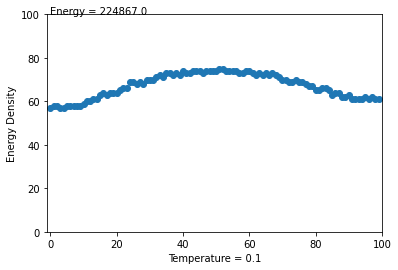

In [3]:
import sys

sys.path.append("DiffusionExample")
from MonteCarlo import MonteCarlo, energy
import numpy as np
import numpy.random as random
from matplotlib import animation
from matplotlib import pyplot as plt
from IPython.display import HTML


Temperature = 0.1

density = [np.sin(i) for i in np.linspace(0.1, 3, 100)]
density = np.array(density) * 100
density = density.astype(int)

fig = plt.figure()
ax = plt.axes(xlim=(-1, len(density)), ylim=(0, np.max(density) + 1))
image = ax.scatter(range(len(density)), density)
txt_energy = plt.text(0, 100, "Energy = 0")
plt.xlabel("Temperature = 0.1")
plt.ylabel("Energy Density")


mc = MonteCarlo(energy, density, temperature=Temperature)


def simulate(step):
    energy, density = mc.step()
    image.set_offsets(np.vstack((range(len(density)), density)).T)
    txt_energy.set_text("Energy = {}".format(energy))


anim = animation.FuncAnimation(fig, simulate, frames=200, interval=50)
HTML(anim.to_jshtml())

In [4]:
%%writefile DiffusionExample/test_model.py
from MonteCarlo import MonteCarlo
from unittest.mock import MagicMock
from pytest import raises, approx


def test_input_sanity():
    """Check incorrect input do fail"""
    energy = MagicMock()

    with raises(NotImplementedError) as exception:
        MonteCarlo(sum, [1, 1, 1], 0e0)
    with raises(ValueError) as exception:
        MonteCarlo(energy, [1, 1, 1], temperature=-1e0)

    with raises(TypeError) as exception:
        MonteCarlo(energy, [1.0, 2, 3])
    with raises(ValueError) as exception:
        MonteCarlo(energy, [-1, 2, 3])
    with raises(ValueError) as exception:
        MonteCarlo(energy, [[1, 2, 3], [3, 4, 5]])
    with raises(ValueError) as exception:
        MonteCarlo(energy, [3])
    with raises(ValueError) as exception:
        MonteCarlo(energy, [0, 0])


def test_move_particle_one_over():
    """Check density is change by a particle hopping left or right."""
    from numpy import nonzero, multiply
    from numpy.random import randint

    energy = MagicMock()

    for i in range(100):
        # Do this n times, to avoid
        # issues with random numbers
        # Create density

        density = randint(50, size=randint(2, 6))
        mc = MonteCarlo(energy, density)
        # Change it
        new_density = mc.change_density(density)

        # Make sure any movement is by one
        indices = nonzero(density - new_density)[0]
        assert len(indices) == 2, "densities differ in two places"
        assert (
            multiply.reduce((density - new_density)[indices]) == -1
        ), "densities differ by + and - 1"


def test_equal_probability():
    """Check particles have equal probability of movement."""
    from numpy import array, sqrt, count_nonzero

    energy = MagicMock()

    density = array([1, 0, 99])
    mc = MonteCarlo(energy, density)
    changes_at_zero = [
        (density - mc.change_density(density))[0] != 0 for i in range(10000)
    ]
    assert count_nonzero(changes_at_zero) == approx(
        0.01 * len(changes_at_zero), 0.5 * sqrt(len(changes_at_zero))
    )


def test_accept_change():
    """Check that move is accepted if second energy is lower"""
    from numpy import sqrt, count_nonzero, exp

    energy = MagicMock()
    mc = MonteCarlo(energy, [1, 1, 1], temperature=100.0)
    # Should always be true.
    # But do more than one draw,
    # in case randomness incorrectly crept into
    # implementation
    for i in range(10):
        assert mc.accept_change(0.5, 0.4)
        assert mc.accept_change(0.5, 0.5)

    # This should be accepted only part of the time,
    # depending on exponential distribution
    prior, successor = 0.4, 0.5
    accepted = [mc.accept_change(prior, successor) for i in range(10000)]
    assert count_nonzero(accepted) / float(len(accepted)) == approx(
        exp(-(successor - prior) / mc.temperature), 3e0 / sqrt(len(accepted))
    )


def test_main_algorithm():
    import numpy as np
    from numpy import testing
    from unittest.mock import Mock

    density = [1, 1, 1, 1, 1]
    energy = MagicMock()
    mc = MonteCarlo(energy, density, itermax=5)

    acceptance = [True, True, True, True, True]
    mc.accept_change = Mock(side_effect=acceptance)
    mc.random_agent = Mock(side_effect=[0, 1, 2, 3, 4])
    mc.random_direction = Mock(side_effect=[1, 1, 1, 1, -1])
    np.testing.assert_equal(mc.step()[1], [0, 1, 1, 2, 1])

Writing DiffusionExample/test_model.py


In [5]:
%%bash
cd DiffusionExample
py.test

============================= test session starts ==============================
platform darwin -- Python 3.7.9, pytest-6.2.4, py-1.10.0, pluggy-0.13.1
rootdir:/home/turingdev/projects/research-software/rse-course/ch03tests/DiffusionExample
plugins: cov-2.12.1, anyio-3.3.0
collected 5 items

test_model.py .....                                                      [100%]

============================== 5 passed in 1.51s ===============================
